# Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases  in Word Embeddings But do not Remove Them

For a detailed explanation of the experiments in this notebook, see:
[paper](https://arxiv.org/pdf/1903.03862.pdf "Lipstick on a Pig paper")

This notebook uses the debiased embeddings described in Zhao et al.

## Preprocessing

### Load embeddings

In [1]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i


def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

def load_wo_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

In [2]:
import string 
from tqdm.notebook import tqdm

def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False



In [3]:
# calculate the avg bias of the vocabulary (abs) before and after debiasing

#def report_bias(gender_bias):
#    bias = 0.0
#    for k in gender_bias:
#        bias += np.abs(gender_bias[k])
#    print(bias/len(gender_bias))
#report_bias(gender_bias_bef)
#report_bias(gender_bias_aft)


In [4]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mpld3
from cycler import cycler
#%matplotlib inline
#mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
#from sklearn.datasets import make_blobs

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    


def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    #Finds the two clusters and the uses TSNE to reduce the dimensions of the clusters for viz
    #The different colors and shapes of the clusters are not the original groups, only the predicted ones
    #TODO: Edit visualization so that it
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_true, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words, y_true, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    #fig.show()
    #fig.savefig(filename, bbox_inches='tight')

    
#Based on ground truth, is there a high cluster quality?
#Use existing labels and calculate the silohuette score
#Find the average vectors for men and women and project one on the other. Same direction would be good.
#An adversary would just fix the most biased words.

In [5]:

def main(orig_embed, debias_embed):
    vocab = {}
    wv = {}
    w2i = {}

    load_and_normalize('bef', orig_embed, vocab, wv, w2i)
    load_wo_normalize('aft', debias_embed, vocab, wv, w2i)

    # remove the last coordinate from the embedding and normalize

    for v in wv['aft']:
        assert(len(v) == 300)
    wv['aft'] = wv['aft'][:,:-1]

    for v in wv['aft']:
        assert(len(v) == 299)

    wv['aft'] = normalize(wv['aft'])

    # create the reduced vocabularies and embeddings before and after, without gendered specific words

    gender_specific = []
    with open('../data/lists/male_word_file.txt') as f:
        for l in f:
            gender_specific.append(l.strip())
    with open('../data/lists/female_word_file.txt') as f:
        for l in f:
            gender_specific.append(l.strip())

    exclude_words = gender_specific
    
    
    
    def limit_vocab(space, exclude = None, vec_len = 300):
        vocab_limited = []
        for w in tqdm(vocab[space][:50000]): 
            if w.lower() != w:
                continue
            if len(w) >= 20:
                continue
            if has_digit(w):
                continue
            if '_' in w:
                p = [has_punct(subw) for subw in w.split('_')]
                if not any(p):
                    vocab_limited.append(w)
                continue
            if has_punct(w):
                continue
            vocab_limited.append(w)

        if exclude:
            vocab_limited = list(set(vocab_limited) - set(exclude))

        print("size of vocabulary:", len(vocab_limited))
    
        wv_limited = np.zeros((len(vocab_limited), vec_len))
        for i,w in enumerate(vocab_limited):
            wv_limited[i,:] = wv[space][w2i[space][w],:]

        w2i_limited = {w: i for i, w in enumerate(vocab_limited)}

        return vocab_limited, wv_limited, w2i_limited

    

    # create spaces of limited vocabulary
    vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
    vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words, vec_len = 299)

    assert(vocab['limit_aft'] == vocab['limit_bef'])

    # Cluster most biased words before and after debiasing
    import operator
    import random
    random.seed(1)
    random_state = 1
    
    # create a dictionary of the bias, before and after
    def compute_bias_by_projection(space_to_tag, full_space):
        males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
        females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
        d = {}
        for w,m,f in zip(vocab[space_to_tag], males, females):
            d[w] = m-f
        return d


    # compute bias-by-projection before and after debiasing
    gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
    gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')
    
    
    #Sort by gender bias
    size = 500
    sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
    female = [item[0] for item in sorted_g[:size]]
    male = [item[0] for item in sorted_g[-size:]]
    
    
    def extract_vectors(words, space1 = 'limit_bef', space2 = 'limit_aft'):
    
        size = len(words)/2
        #wv is a list of word vectors, w2i lookup by word
        X_bef = [wv[space1][w2i[space1][x],:] for x in words]
        X_aft = [wv[space2][w2i[space2][x],:] for x in words]

        return X_bef, X_aft
    

    X_bef, X_aft = extract_vectors(male + female)
    y_true = [0]*size + [1]*size
    cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)
    print("Before debiasing Silhouette Score: ", silhouette_score(X_bef, y_true, metric='l2'))
    print("After debiasing Silhouette Score: ", silhouette_score(X_aft, y_true, metric='l2'))
    print("Before debiasing Davies-Bouldin score: ", davies_bouldin_score(X_bef, y_true))
    print("After debiasing Davies-Bouldin score: ", davies_bouldin_score(X_aft, y_true))
    print("Before debiasing Calinski and Harabasz score: ", calinski_harabasz_score(X_bef, y_true))
    print("After debiasing Calinski and Harabasz score: ", calinski_harabasz_score(X_aft, y_true))

    return X_bef, X_aft, y_true

loading ...
done
loading ...
done



size of vocabulary: 47698



size of vocabulary: 47698


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision bef 1.0


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision aft 0.818
Before debiasing Silhouette Score:  0.06570841555811151
After debiasing Silhouette Score:  0.02658829092523065
Before debiasing Davies-Bouldin score:  3.7211584683436203
After debiasing Davies-Bouldin score:  6.045973223226498
Before debiasing Calinski and Harabasz score:  71.94832271532631
After debiasing Calinski and Harabasz score:  27.237587216625357


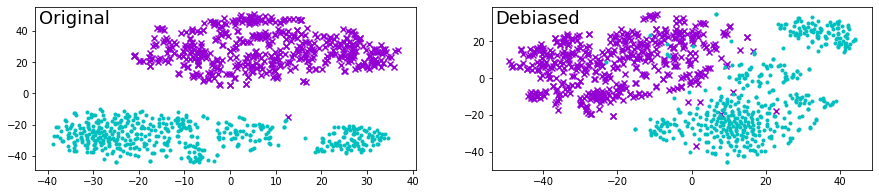

In [6]:
dhd_glove_bef, dhd_glove_aft, dhd_glove_true = main('../data/Zhao/orig_glove', '../data/Wang/dhd_glove')

loading ...
done
loading ...
done



size of vocabulary: 47698



size of vocabulary: 47698


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision bef 1.0


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision aft 0.856
Before debiasing Silhouette Score:  0.06570841555811151
After debiasing Silhouette Score:  0.04679066221346251
Before debiasing Davies-Bouldin score:  3.7211584683436203
After debiasing Davies-Bouldin score:  4.476510119800325
Before debiasing Calinski and Harabasz score:  71.94832271532631
After debiasing Calinski and Harabasz score:  49.73094392216819


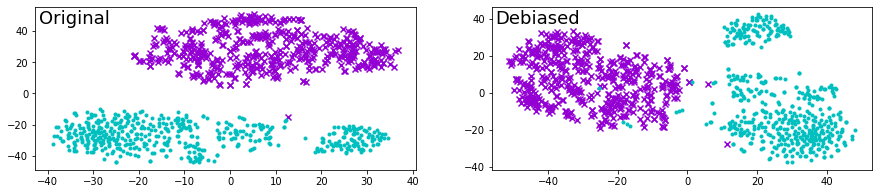

In [7]:
gn_glove_bef, gn_glove_aft, gn_glove_true = main('../data/Zhao/orig_glove', '../data/Zhao/gn_glove')

loading ...
done
loading ...
done



size of vocabulary: 26169



size of vocabulary: 26169


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision bef 0.999


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision aft 0.079
Before debiasing Silhouette Score:  0.05506059257260303
After debiasing Silhouette Score:  0.02382201186347662
Before debiasing Davies-Bouldin score:  4.088958900553604
After debiasing Davies-Bouldin score:  6.362293775863312
Before debiasing Calinski and Harabasz score:  59.63221979283561
After debiasing Calinski and Harabasz score:  24.635924333005818


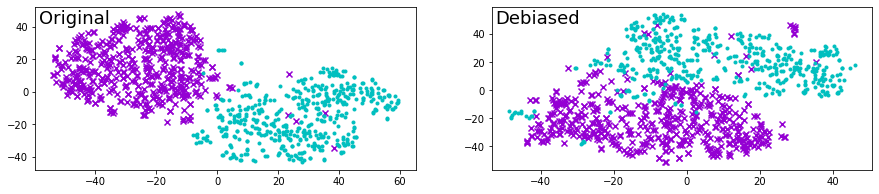

In [8]:
hd_w2v_bef, hd_w2v_glove_aft, hd_w2v_true = main('../data/Bolukbasi/orig_w2v', '../data/Bolukbasi/hard_debiased_w2v')

loading ...
done
loading ...
done



size of vocabulary: 26169



size of vocabulary: 26169


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision bef 0.999


/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gridsan/cwarn/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision aft 0.202
Before debiasing Silhouette Score:  0.05506059257260303
After debiasing Silhouette Score:  0.020033876341036736
Before debiasing Davies-Bouldin score:  4.088958900553604
After debiasing Davies-Bouldin score:  6.9679577328895554
Before debiasing Calinski and Harabasz score:  59.63221979283561
After debiasing Calinski and Harabasz score:  20.54111936775989


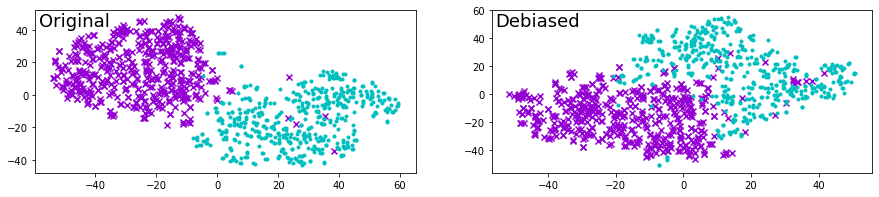

In [10]:
dhd_w2v_bef, dhd_w2v_aft, dhd_w2v_true = main('../data/Bolukbasi/orig_w2v', '../data/dhd_w2v/dhd_w2v')

In [ ]:
y_pred_bef = KMeans(n_clusters=2, random_state=1).fit_predict(dhd_glove_bef)
silhouette_score(dhd_glove_bef, dhd_glove_true)

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(2, random_state=1)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(np.array(dhd_glove_bef))
visualizer.show()